#  Standards - Calculate minimum standoff distance for roof mounted systems

This example demonstrates the calculation of a minimum standoff distance necessary for roof-mounted PV modules to ensure that the $T_{98}$ operational temperature remains under 70°C, in which case the more rigorous thermal stability testing requirements of IEC TS 63126 would not needed to be considered. We use data from [Fuentes, 1987] to model the approximate exponential decay in temperature, $T(X)$, with increasing standoff distance, $X$, as,

$$ X = -X_0 \ln\left(1-\frac{T_0-T}{\Delta T}\right)$$

where $T_0$ is the temperature for $X=0$ (insulated back) and $\Delta T$ is the temperature difference between an insulated back ($X=0$) and open rack mounting configuration ($X=\infty)$.

The following figure showcases this calulation for the entire United States. We used pvlib and data from the National Solar Radiation Database (NSRDB) to calculate the module temperatures for different mounting configuration and applied our model to obtain the standoff distance for roof-mounted PV systems.

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from rex import NSRDBX
from rex import Outputs
from rex import Resource
import os
import glob

In [42]:
import pvlib
import pvdeg

# PVD - Single location example

In [43]:
#Get weather data
weather_db = 'NSRDB'
weather_id = (39.741931, -105.169891)
weather_id = 1933572  
weather_arg = {'satellite' : 'GOES', 
               'names' : 2021, 
               'NREL_HPC' : True,
               'attributes' : ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni','relative_humidity']}

weather_df, meta = pvd.weather.load(weather_db, weather_id, **weather_arg)

In [44]:
#Perform calculation
res = calc_standoff(weather_df, meta, tilt=None, azimuth=180, sky_model='isotropic', temp_model='sapm', 
                    module_type='glass_polymer', level=1, x_0=6.1)
print(res)

{'x': 3.4904744924590707, 'T98_0': 82.57377792878141, 'T98_inf': 53.7164637250924}


# PVD - Subsampling

In [45]:
def gid_downsampling(meta, n):   
    lon_sub = sorted(meta['longitude'].unique())[0:-1:max(1,2*n)]
    lat_sub = sorted(meta['latitude'].unique())[0:-1:max(1,2*n)]

    gids_sub = meta[(meta['longitude'].isin(lon_sub)) & 
                    (meta['latitude'].isin(lat_sub))].index

    meta_sub = meta.loc[gids_sub]
    
    return meta_sub, gids_sub

In [46]:
# region = 'United States'
# region_col = 'country'
region = 'Colorado'
region_col = 'state'

nsrdb_file = '/datasets/NSRDB/current/nsrdb_tmy-2021.h5'
with NSRDBX(nsrdb_file, hsds=False) as f:
    # Get time index
    times = f.time_index
    # Get geographical index for region of interest
    gids = f.region_gids(region=region, region_col=region_col)   
    # Get meta data
    meta = f.meta[f.meta.index.isin(gids)]

In [47]:
meta.loc[389876]

latitude         38.490002
longitude      -109.059998
elevation             2300
timezone                -7
country      United States
state             Colorado
county            Montrose
Name: 389876, dtype: object

In [48]:
n = 2 #Downsampling factor
meta_sub, gids_sub = gid_downsampling(meta, n)

In [49]:
gids_sub

Int64Index([389877, 389881, 393321, 393325, 393329, 393333, 393337, 393341,
            393345, 393349,
            ...
            557645, 557649, 557653, 557657, 557661, 557665, 557669, 557673,
            557677, 557681],
           dtype='int64', name='gid', length=1077)

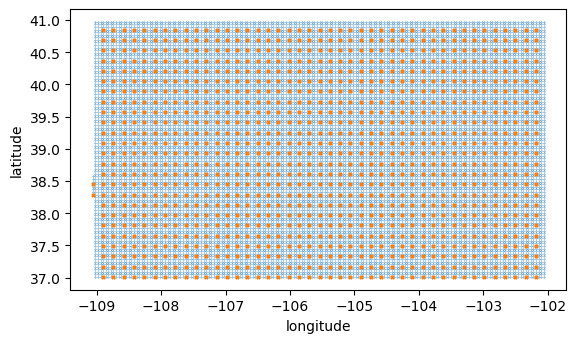

In [50]:
fig, ax = plt.subplots()

sc = ax.scatter(meta['longitude'], meta['latitude'], s=0.1)
sc = ax.scatter(meta_sub['longitude'], meta_sub['latitude'], s=5, marker='x')

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_aspect('equal', adjustable='box')

plt.show()

# Create meta world map

In [51]:
full_disk_fp = '/datasets/NSRDB/full_disc/nsrdb_full_disc_pv_2021.h5'
meteosat_fp = '/datasets/NSRDB/meteosat/meteosat_pv_2019.h5'
himawari_fp = '/datasets/NSRDB/himawari/himawari_tmy-2020.h5'

with NSRDBX(full_disk_fp, hsds=False) as f:
    meta_full_disk = f.meta
    
with NSRDBX(meteosat_fp, hsds=False) as f:
    meta_meteosat = f.meta
    
with NSRDBX(himawari_fp, hsds=False) as f:
    meta_himawari = f.meta

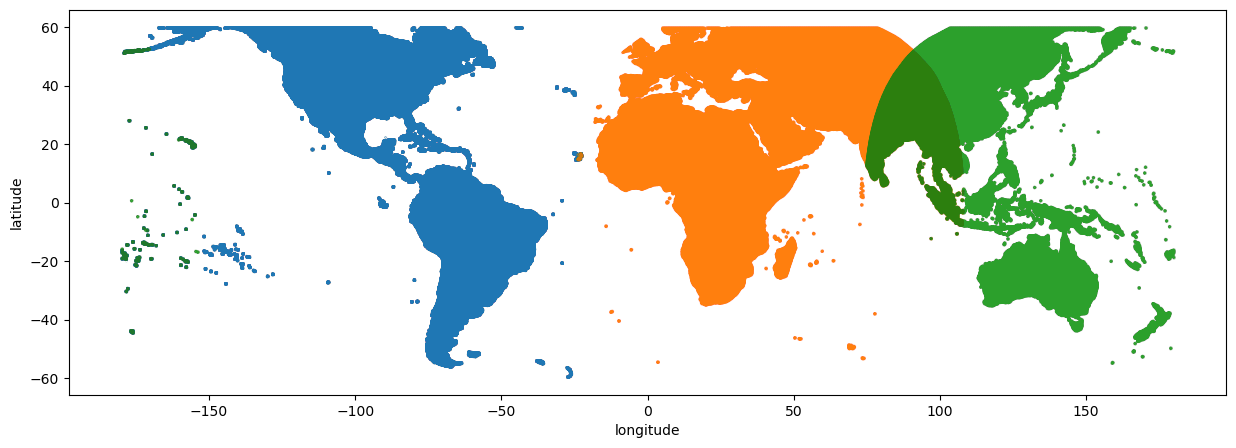

In [52]:
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(meta_full_disk['longitude'], meta_full_disk['latitude'], s=0.001, alpha=0.5)
ax.scatter(meta_meteosat['longitude'], meta_meteosat['latitude'], s=0.001, alpha=0.5)
ax.scatter(meta_himawari['longitude'], meta_himawari['latitude'], s=0.001, alpha=0.5)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_aspect('equal', adjustable='box')
plt.show()

In [53]:
# meta_full_disk_sub, gids_full_disk = gid_downsampling(meta_full_disk, n=15)
# meta_meteosat_sub, gids_meteosat = gid_downsampling(meta_meteosat, n=10)
# meta_himawari_sub, gids_himawari = gid_downsampling(meta_himawari, n=10)

# print(len(gids_full_disk))
# print(len(gids_meteosat))
# print(len(gids_himawari))

In [55]:
meta_full_disk_sub, gids_full_disk = gid_downsampling(meta_full_disk, n=6)
meta_meteosat_sub, gids_meteosat = gid_downsampling(meta_meteosat, n=6)
meta_himawari_sub, gids_himawari = gid_downsampling(meta_himawari, n=6)

In [56]:
print(len(gids_full_disk))
print(len(gids_meteosat))
print(len(gids_himawari))

65688
26827
15006


In [57]:
df_gids_GOES = pd.DataFrame(gids_full_disk, columns=['gid'])
df_gids_GOES.to_csv('gids_GOES_n6.csv', index=False)

df_gids_METEOSAT = pd.DataFrame(gids_meteosat, columns=['gid'])
df_gids_METEOSAT.to_csv('gids_METEOSAT_n6.csv', index=False)

df_gids_Himawari = pd.DataFrame(gids_himawari, columns=['gid'])
df_gids_Himawari.to_csv('gids_Himawari_n6.csv', index=False)

In [58]:
meta_full_disk_sub.to_csv('meta_GOES_n6.csv', index=True)
meta_meteosat_sub.to_csv('meta_METEOSAT_n6.csv', index=True)
meta_himawari_sub.to_csv('meta_Himawari_n6.csv', index=True)

In [59]:
meta_world_map_aux = pd.read_csv('../data/meta_world_map_aux.csv', index_col=0)

In [60]:
meta_full_disk_sub['weather_db'] = 'NSRDB'
meta_meteosat_sub['weather_db'] = 'NSRDB'
meta_himawari_sub['weather_db'] = 'NSRDB'

meta_full_disk_sub['weather_satellite'] = 'GOES'
meta_full_disk_sub['weather_names'] = 2021
meta_meteosat_sub['weather_satellite'] = 'METEOSAT'
meta_meteosat_sub['weather_names'] = 2019
meta_himawari_sub['weather_satellite'] = 'Himawari'
meta_himawari_sub['weather_names'] = 'TMY'

col_names = meta_full_disk_sub.columns.to_list() + ['weather_file']
col_names.remove('state')
col_names.remove('weather_satellite')
col_names.remove('weather_names')

In [61]:
meta_world = pd.concat([meta_full_disk_sub, meta_meteosat_sub, meta_himawari_sub, meta_world_map_aux[col_names]])
meta_world.to_csv('meta_world_n6.csv', index=True)

In [62]:
meta_world_test = pd.concat([meta_full_disk_sub[0:5], meta_meteosat_sub[0:5], meta_himawari_sub[0:5], meta_world_map_aux[col_names][0:5]])
meta_world_test.to_csv('meta_world_test.csv', index=True)

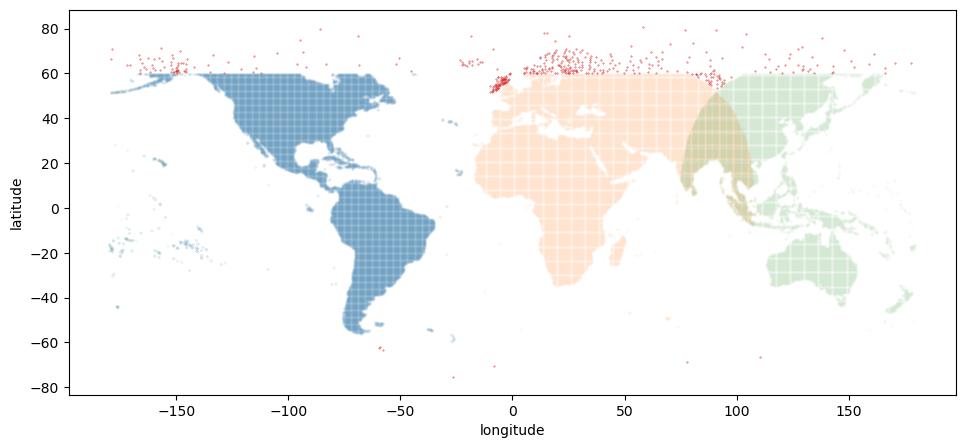

In [65]:
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(meta_full_disk_sub['longitude'], meta_full_disk_sub['latitude'], s=0.001)
ax.scatter(meta_meteosat_sub['longitude'], meta_meteosat_sub['latitude'], s=0.001)
ax.scatter(meta_himawari_sub['longitude'], meta_himawari_sub['latitude'], s=0.001)
ax.scatter(meta_world_map_aux['longitude'], meta_world_map_aux['latitude'], s=0.1)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_aspect('equal', adjustable='box')

plt.show()

# Testing

In [66]:
meta_world_test = pd.read_csv('meta_world_test.csv', index_col=0)

In [67]:
meta_world_test

,latitude,longitude,elevation,timezone,country,state,county,weather_db,weather_satellite,weather_names,weather_file
gid,,,,,,,,,,,
3,-16.000000,-179.990005,0.0,12.0,NaN,NaN,NaN,NSRDB,GOES,2021,NaN
15,-16.240000,-179.990005,0.0,12.0,NaN,NaN,NaN,NSRDB,GOES,2021,NaN
27,-16.480000,-179.990005,0.0,12.0,Fiji,Northern,Cakaudrove,NSRDB,GOES,2021,NaN
39,-16.719999,-179.990005,0.0,12.0,NaN,NaN,NaN,NSRDB,GOES,2021,NaN
51,-16.959999,-179.990005,0.0,12.0,NaN,NaN,NaN,NSRDB,GOES,2021,NaN
213,15.450000,-23.780001,0.0,-1.0,None,None,None,NSRDB,METEOSAT,2019,NaN
225,14.970000,-23.780001,0.0,-1.0,None,None,None,NSRDB,METEOSAT,2019,NaN
466,15.450000,-23.299999,0.0,-1.0,None,None,None,NSRDB,METEOSAT,2019,NaN
478,14.970000,-23.299999,0.0,-1.0,None,None,None,NSRDB,METEOSAT,2019,NaN


In [71]:
weather_arg = {}
weather_arg['NREL_HPC'] = True  #TODO: add argument or auto detect
weather_arg['attributes'] = [
    'air_temperature', 
    'wind_speed', 
    'dhi', 
    'ghi', 
    'dni',
    'relative_humidity'
    ]

In [72]:
for idx, point in meta_world_test[15:].iterrows():
    gid = idx #int(point.gid)
    database = point.weather_db
    df_weather_kwargs = point.drop('weather_db', inplace=False).filter(like='weather_')
    df_weather_kwargs.index = df_weather_kwargs.index.map(lambda arg: arg.lstrip('weather_'))
    weather_kwarg = weather_arg | df_weather_kwargs.to_dict()
    
    weather_df, meta = pvd.weather.load(
                database = database, 
                id = gid, 
                #satellite = point.satellite,  #TODO: check input
                **weather_kwarg)

In [73]:
calc_standoff(weather_df, meta, tilt=None, azimuth=180, sky_model='isotropic', temp_model='sapm', 
                    module_type='glass_polymer', level=1, x_0=6.1)

{'x': -8.840344487847759,
 'T98_0': 25.27397605779635,
 'T98_inf': 11.553756660714853}